In [1]:
import pandas as pd
import json
import os
from base64 import b64encode, b64decode
import matplotlib.pyplot as plt
import cv2

# Dataset ingest

In [2]:
class Caja(object):
    """Clase que define la estructura de datos del segmento etiquetado (bounding-box) como unidad."""
    def __init__(self, archivo, bounding_box, etiqueta, contenido):
        self.file = archivo
        self.x_1 = bounding_box['x']
        self.y_1 = bounding_box['y']
        self.x_2 = bounding_box['x'] + bounding_box['w'] 
        self.y_2 = bounding_box['y'] + bounding_box['h']
        self.content = contenido
        self.label = etiqueta
        
    def to_json(self):
        return self.__dict__
    
    def to_pd_series(self):
        return pd.Series(self.__dict__)

In [3]:
def get_segments_from_annotations(path_json, df):
    """Función que extrae cada segmento de cada artículo existente en formato json en el 
    directorio 'path_json'. Retorna un dataframe con la totalidad de los segmentos."""
    
    features = ['file', 'x_1','y_1','x_2','y_2','label', 'content']

    df = pd.DataFrame(columns=features)

    for filename in os.listdir(path_json):
        if filename.endswith(".json"):
            file_path = os.path.join(path_json, filename)
            with open(file_path, "r") as json_file:
                datos = json.load(json_file)
            
            for nota in datos['Notas']:
                for segmento in nota:
                    for detalle in nota[segmento]:
                        try:
                            caja = Caja(filename.replace('.json', '.tif'), detalle['bounding_box'], segmento, detalle['text'])
                            df = df.append(caja.to_pd_series(), ignore_index=True)
                            #print(f'Archivo: {caja.file} | Segmento: {segmento}  | Estado OK!')
                        except:
                            print(f'Archivo: {caja.file} | Segmento: {segmento}  | Estado ERROR!')
    return df

In [4]:
def load_images_from_dir(path_tif, df):
    """Función que extrae cada segmento de cada nota. Retorna un dataframe con la totalidad de los segmentos."""
    
    df = pd.DataFrame()

    for filename in os.listdir(path_tif):
        if filename.endswith(".tif"):
            tif_file = os.path.join(path_tif, filename)
            
        imagen_cv = cv2.imread(tif_file)
        img_dict = {}
        img_dict['file'] = filename
        img_dict['bitmap'] = imagen_cv
        img_dict['height'] = imagen_cv.shape[0]
        img_dict['width'] = imagen_cv.shape[1]

        df = df.append(img_dict, ignore_index=True)

    return df

def show_image(imagen_cv):
    """Función que imprime una imagen previamente cargada con cv2."""
    plt.axis('off')
    plt.imshow(imagen_cv)
    
def draw_rectangle_annotations(s_imagen, df_segmentos):
    """Función que sobreimprime los bounding boxes desde la tabla df_segmentos
    sobre la imagen correspondiente al registro de imagen s_imagen."""
    img_file = s_imagen['file']
    imagen = s_imagen['bitmap']
    segmentos = df_segmentos[df_segmentos['file']==img_file]
    for segmento in segmentos.itertuples():
        x_1 = segmento[2]
        y_1 = segmento[3]
        x_2 = segmento[4]
        y_2 = segmento[5]
        cv2.rectangle(imagen, (x_1, y_1), (x_2, y_2), (36,255,12), 2)
    show_image(imagen)
    


In [5]:
path_json = 'iaxidentidad_json'
path_tif = 'iaxidentidad_tif'
path_output = 'output_csv'

df_segmentos = pd.DataFrame()
df_imagenes = pd.DataFrame()

df_segmentos = get_segments_from_annotations(path_json, df_segmentos)
df_imagenes = load_images_from_dir(path_tif, df_imagenes)

In [6]:
df_segmentos.head()

,file,x_1,y_1,x_2,y_2,label,content
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender..."


In [7]:
df_imagenes.head()

,file,bitmap,height,width
0,Crónica 1983-12-14 General Weher Justifico tod...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",971.0,1672.0
1,La Razon 1986-12-05 Los senadores de la Renova...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1009.0,1202.0
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",252.0,945.0


In [8]:
articulo = df_imagenes.iloc[2]
articulo

file      La Gaceta de hoy 1986-12-24 Arosa descartó un ...
bitmap    [[[255, 255, 255], [255, 255, 255], [255, 255,...
height                                                252.0
width                                                 945.0
Name: 2, dtype: object

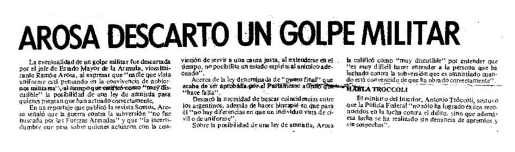

In [9]:
show_image(articulo['bitmap'])

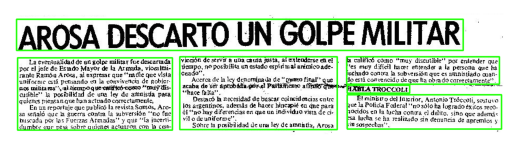

In [10]:
draw_rectangle_annotations(articulo, df_segmentos)

## Exportación a csv

In [11]:
df_segmentos.to_csv(path_output + '/data_segments.csv')
df_imagenes.to_csv(path_output + '/data_images.csv')